# Model Learning Curves

In [2]:
%load_ext autoreload
%autoreload 2

!export JAX_ENABLE_X64=True

# Core libraries
import itertools
import os
import time

import h5py

from functools import partial

# JAX imports
import jax

import jax.scipy.optimize as joptimize
import jax.scipy.stats as jstats
import jax.nn as jnn
import jax.numpy as jnp

from jax import grad, vmap, jacfwd

# Other imports
import lcdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from scipy.optimize import least_squares, minimize
from tqdm.notebook import tqdm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import check_random_state

from lcmodel import *

## Modeling the evolution of the budget

The budget is a function of type $b(z;\nu)$ where $z \in [1;\infty[$ model the evolution of points observed. For example $z$ can be the number of iterations in a loop but the budget can be increase of 3 at each iteration.

For a linear budget we have (e.g., number of epochs):
$$b_\text{lin2}(z;\nu) = \nu_1 (z-1) + \nu_0$$

For an exponential budget we have (e.g., number of samples used to train the model):
$$b_\text{exp2}(z;\nu) = \nu_0 \cdot \nu_1^{z-1}$$

For example in the HPO benchmark the budget is evolving linearly with respect to the number of epochs. However in the LCDB benchmark the budget is evolving exponentially with respect to the number of samples.

---

**Specification du problem**:
* Maximiser ALC (Multi-Obj ramene a 1 seul objectif).
* Les $z$ sont fixes et discret.
* $b(z)$ est fixe par le client (comment on va faire evoluer le budget).

In [3]:
b_lin2??

Signature: b_lin2(z, nu=[1, 1])
Docstring: <no docstring>
Source:   
def b_lin2(z, nu=[1, 1]):
    return nu[1] * (z-1) + nu[0]
File:      ~/Documents/Argonne/deephyper-scalable-bo/notebooks/learning-curves/lcmodel.py
Type:      function


In [4]:
b_exp2??

Signature: b_exp2(z, nu=[1, 2])
Docstring: <no docstring>
Source:   
def b_exp2(z, nu=[1, 2]):
    return nu[0] * jnp.power(nu[1], z-1)
File:      ~/Documents/Argonne/deephyper-scalable-bo/notebooks/learning-curves/lcmodel.py
Type:      function


## Modeling a Learning Curve

In this section, we display some possible model of a learning curve. The learning curve function model is generaly monotonicly increasing.

The `pow3` function parameters are easy to interpret:
- $\rho_0$ defines the value of convergence when $z \rightarrow +\infty$
- $\rho_1$ defines the value at step 1 (at the beginning)
- $\rho_2$ defines the convergence speed

We will use `pow3` to build our toy problem and check the soundness of our approach.

The other models `wbl4` and `mmf4` are studied in the LCDB paper and in the top ranked for extrapolation.

### Function: POW3 
Also called the *Inverse Power Law* model.

$$f_\text{pow3}(b;\rho) = \rho_0 - \rho_1 \cdot b(z;\nu)^{-\rho_2}$$

### Function: WBL4

$$f_\text{wbl4}(b;\rho) = -\rho_1 \exp(-\rho_0 b(z;\nu)^{\rho_3}) + \rho_2$$

### Function: MMF4

$$f_\text{mmf4}(b;\rho) = \frac{\rho_0 \rho_1 + \rho_2 b(z;\nu)^{\rho_3}}{\rho_1 + b(z;\nu)^{\rho_3}}$$


### Simplification for $b(z) = z$

Of course, the budget evolution is sometimes very simple, for example increase by one each time, which means that the budget function follows $b(z) = z$, its derivative w.r.t. $z$ will be constant and equal to 1. In this case, there is no need to use the heavy $b(z)$ notation, it can be replaced by $b \sim b(z)$ directly everywhere and similarly $b$ can be used instead of $z$.

In [5]:
f_lin2??

Signature: f_lin2(z, b, rho)
Docstring: <no docstring>
Source:   
def f_lin2(z, b, rho):
    return rho[1] * b(z) + rho[0]
File:      ~/Documents/Argonne/deephyper-scalable-bo/notebooks/learning-curves/lcmodel.py
Type:      function


In [6]:
f_loglin2??

Signature: f_loglin2(z, b, rho)
Docstring: <no docstring>
Source:   
def f_loglin2(z, b, rho):
    Z = jnp.log(z)
    Y = rho[1] * Z + rho[0]
    y = jnp.exp(Y)
    return y
File:      ~/Documents/Argonne/deephyper-scalable-bo/notebooks/learning-curves/lcmodel.py
Type:      function


In [7]:
f_mmf4??

Signature: f_mmf4(z, b, rho)
Docstring: <no docstring>
Source:   
def f_mmf4(z, b, rho):
    return (rho[0] * rho[1] + rho[2] * jnp.power(b(z), rho[3])) / (rho[1] + jnp.power(b(z), rho[3]))
File:      ~/Documents/Argonne/deephyper-scalable-bo/notebooks/learning-curves/lcmodel.py
Type:      function


In [8]:
f_pow3??

Signature: f_pow3(z, b, rho)
Docstring: <no docstring>
Source:   
def f_pow3(z, b, rho):
    return rho[0] - rho[1] * b(z)**-rho[2]
File:      ~/Documents/Argonne/deephyper-scalable-bo/notebooks/learning-curves/lcmodel.py
Type:      function


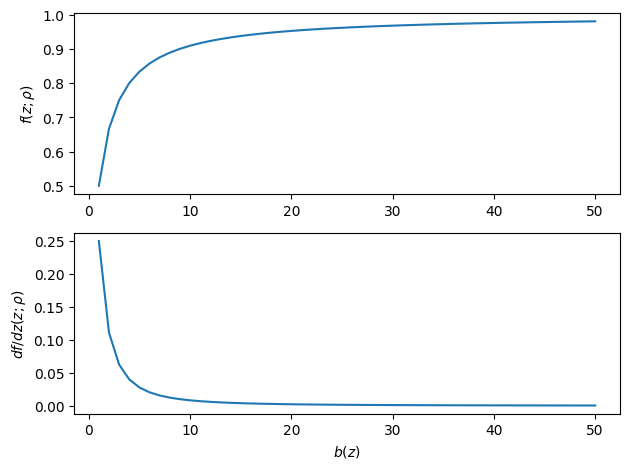

In [9]:
# modeling the iterations
z_max = 50
z = (np.arange(z_max) + 1).astype(float)

# modeling the budget

# linear budget
b = lambda z: b_lin2(z, nu=[1,1])

# exponential budget
# b = lambda z: exp_budget(z, nu=[1, np.sqrt(2)])

vb = vmap(b)

# modeling the learning curve function
rho_mmf4 = (1e-6, 1.0, 1.0, 1.0)
f = lambda z: f_mmf4(z, b, rho_mmf4)

# learning curve with linear improvements
# rho_linear = (1.0, 0.0)
# f = lambda z: f_linear(z, b, rho_linear)

vf = vmap(f)

# retrieving the gradients with auto-diff
# vmap to parallelize over z but not b and rho
df = grad(f)
db = grad(b)

vdf = vmap(df) 
vdb = vmap(db)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(vb(z), vf(z))
plt.ylabel(r"$f(z;\rho)$")

plt.subplot(2, 1, 2)
plt.plot(vb(z), vdf(z))
plt.ylabel(r"$df/dz(z;\rho)$")
plt.xlabel(r"$b(z)$")

plt.tight_layout()
plt.show()

## Modeling the Utility

By taking inspiration from the formula of the Bayesian Information Criterion we write the following utility function:

$$u(z;\delta) = \frac{z}{z_\text{max}} \log \frac{f'(z)}{\delta \cdot b'(z)}$$

By identification:

$$u(z;\delta) = \frac{z}{z_\text{max}} \log \frac{1}{\delta} \cdot \frac{f'(b(z))}{b'(z)}$$

We can set $\delta = f'(z_\text{max})/b'(z_\text{max})$ to have normalized tradeoff w.r.t. to the variable $z$ the number of iterations, independantly of the budget function $b(z)$.

In [10]:
def u_log(z, delta, z_max, b, db, df):
    return z / z_max * jnp.log(df(z)/(delta * db(z)))

delta=0.00038446858525276184


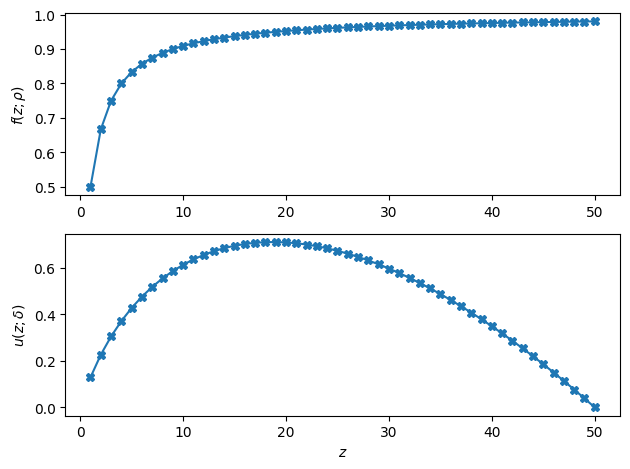

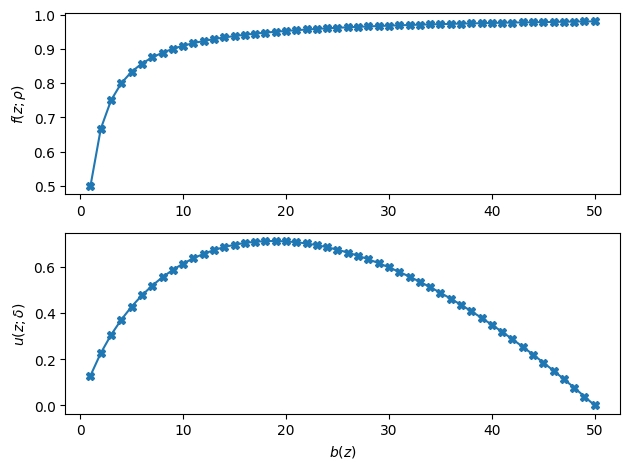

In [11]:
# delta can be interpreted to set the "utility" as we want
# for example if a gain of 0.001 after 10 iterations is inefficient
# we can set it such as follow to set the maximum of utility at this
# point
# delta = 1.0
# delta = 0.001
# delta = 0.01/b(50) # OK when linear budget b(z)

# a way to set delta
delta =  df(float(z_max)) / db(float(z_max))

delta = float(delta)
print(f"{delta=}")

u = lambda z: u_log(z, delta, float(z_max), b, db, df)

vu = vmap(u)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(z, f(z), marker="X")
plt.ylabel(r"$f(z;\rho)$")

plt.subplot(2, 1, 2)
plt.plot(z, vu(z), marker="X")
plt.ylabel(r"$u(z;\delta)$")
plt.xlabel(r"$z$")

plt.tight_layout()
plt.show()

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(vb(z), f(z), marker="X")
plt.ylabel(r"$f(z;\rho)$")

plt.subplot(2, 1, 2)
plt.plot(vb(z), vu(z), marker="X")
plt.ylabel(r"$u(z;\delta)$")
plt.xlabel(r"$b(z)$")

plt.tight_layout()
plt.show()

## Non-Linear Least Square for LC-Model Parameters Estimation

In this section we do not model the noise.

In [12]:
# The combination of "partial" and "static_argnums" is necessary
# with the "f" lambda function passed as argument
@partial(jax.jit, static_argnums=(1,))
def residual_least_square(rho, f, z, y):
    """Residual for least squares."""
    return f(z, rho) - y


def fit_learning_curve_model_least_square(f, nparams, z_train, y_train, use_jac=True, max_trials=100, random_state=None):
    """The learning curve model is assumed to be modeled by 'f' with
    interface f(z, rho).
    """
    
    random_state = check_random_state(random_state)
    
    z_train = np.asarray(z_train)
    y_train = np.asarray(y_train)
        
    # compute the jacobian
    # using the true jacobian is important to avoid problems
    # with numerical errors and approximations! indeed the scale matters
    # a lot when approximating with finite differences
    fun_wrapper = lambda rho, f, z, y: np.array(residual_least_square(rho, f, z, y))
    
    jac_residual = partial(jax.jit, static_argnums=(1,))(jacfwd(residual_least_square, argnums=0))
    jac_wrapper = lambda rho, f, z, y: np.array(jac_residual(rho, f, z, y))

    mean_est = np.mean(y_train)
    mse_mean_est = np.mean((mean_est - y_train) ** 2)
    
    results = []
    mse_hist = []
    tol = mse_mean_est
        
    for i in range(max_trials):
        
        rho_init = random_state.randn(nparams)
        
        try:
            res_lsq = least_squares(
                fun_wrapper,
                rho_init,
                args=(f, z_train, y_train),
                method="lm",
                jac=jac_wrapper if use_jac else "2-point",
            )
        except ValueError:
            continue

        mse_res_lsq = np.mean(res_lsq.fun**2)
        mse_hist.append(mse_res_lsq)
        results.append(res_lsq.x)
        
    i_best = np.nanargmin(mse_hist)
    res = results[i_best]
    return res

### Toy-Example from Inverse Power Law

<function <lambda> at 0x2aa8894c0>


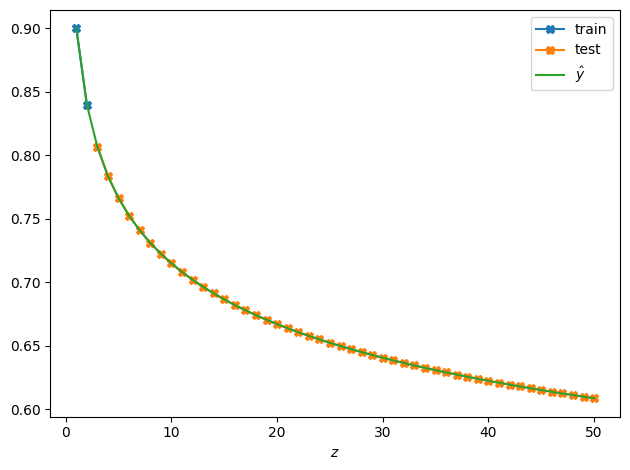

In [13]:
k = 2
rho_pow3 = (1.0, 0.9, 0.1)
y = 1 - f_pow3(z, b, rho_pow3)

z_train, y_train = z[:k], y[:k]
z_test, y_test = z[k:], y[k:]

# nparams = 4
# f_model = lambda z, rho: f_mmf4(z, b, rho)

nparams = 2
f_model = lambda z, rho: f_loglin2(z, b, rho)

# nparams = 3
# f_model = lambda z, rho: f_pow3(z, b, rho)

print(f_model)

rho_hat = fit_learning_curve_model_least_square(f_model, nparams, z_train, y_train, use_jac=True)
y_hat = f_model(z, rho_hat)

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")
plt.plot(z, y_hat, label=r"$\hat{y}$")
plt.xlabel(r"$z$")
plt.legend()
# plt.yscale("log")
# plt.xscale("log")

plt.tight_layout()
plt.show()

In [14]:
print(f_model(20, rho_hat))
print(f_model(100, rho_hat))
print(f"{rho_hat=}")

0.667021
0.5678616
rho_hat=array([-0.10536054, -0.1       ])


### Learning Curves from LCDB

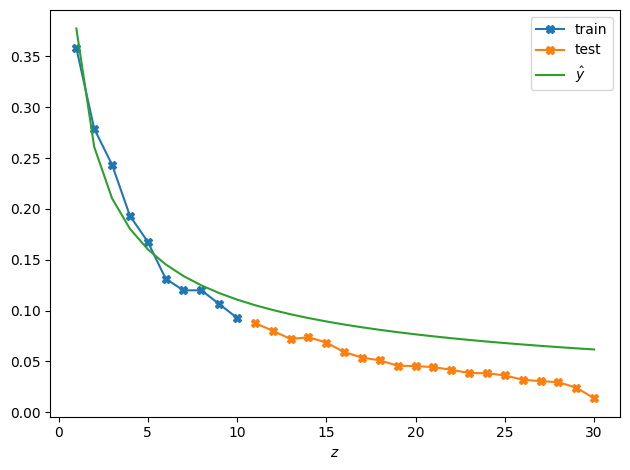

In [15]:
task_id = 351
model = "sklearn.ensemble.ExtraTreesClassifier"

curve = lcdb.get_curve(task_id, model)
anchors, _, scores_valid, _ = curve
anchors = np.array(anchors)
scores_valid = 1 - np.array(scores_valid)
# scores_valid = np.array(scores_valid)

b_lcdb = lambda z: b_exp2(z, nu=[anchors[0], jnp.sqrt(2)])

k = 10

# nparams = 4
# f_model_lcdb = lambda z, rho: f_mmf4(z, b_lcdb, rho)

# nparams = 3
# f_model_lcdb = lambda z, rho: f_pow3(z, b_lcdb, rho)

nparams = 2
f_model_lcdb = lambda z, rho: f_loglin2(z, b_lcdb, rho)

# nparams = 4
# f_model_lcdb = lambda z, rho: f_loglin4(z, b_lcdb, rho)

k = max(nparams, k)

z_lcdb = np.arange(len(anchors)) + 1
z_lcdb_train, y_lcdb_train = z_lcdb[:k], scores_valid[:k, 0]
z_lcdb_test, y_lcdb_test = z_lcdb[k:], scores_valid[k:, 0]

rho_hat_lcdb = fit_learning_curve_model_least_square(f_model_lcdb, nparams, z_lcdb_train, y_lcdb_train, use_jac=True)
y_hat_lcdb = f_model_lcdb(z_lcdb, rho_hat_lcdb)

plt.figure()

plt.plot(z_lcdb_train, y_lcdb_train, marker="X", label="train")
plt.plot(z_lcdb_test, y_lcdb_test, marker="X", label="test")
plt.plot(z_lcdb, y_hat_lcdb, label=r"$\hat{y}$")
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

### Trying out some linear models

[-0.42150481]


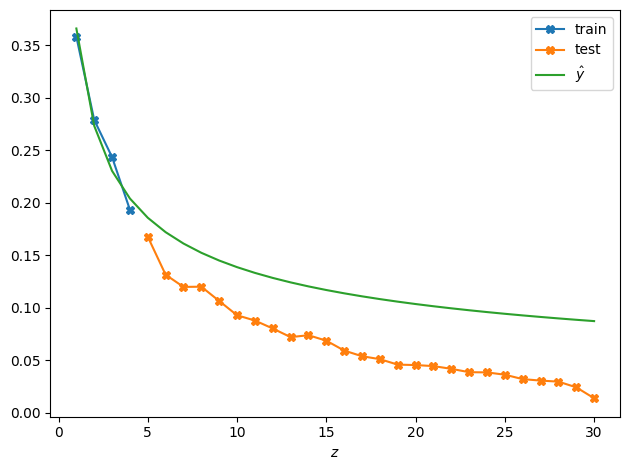

In [16]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

# lm = make_pipeline(
#     FunctionTransformer(func=lambda x: np.log(x)),
#     LinearRegression(),
#     FunctionTransformer(func=lambda x: np.exp(x)),
# )
lm = LinearRegression(n_jobs=-1)
# lm = Ridge()

task_id = 351
model = "sklearn.ensemble.ExtraTreesClassifier"

curve = lcdb.get_curve(task_id, model)
anchors, _, scores_valid, _ = curve
anchors = np.array(anchors)
scores_valid = 1 - np.array(scores_valid)

b_lcdb = lambda z: b_exp2(z, nu=[anchors[0], jnp.sqrt(2)])

k = 4

z_lcdb = np.arange(len(anchors)) + 1
z_lcdb_train, y_lcdb_train = z_lcdb[:k], scores_valid[:k, 0]
z_lcdb_test, y_lcdb_test = z_lcdb[k:], scores_valid[k:, 0]


# rho_hat_lcdb = fit_learning_curve_model_least_square(f_model_lcdb, nparams, z_lcdb_train, y_lcdb_train, use_jac=True)
# y_hat_lcdb = f_model_lcdb(z_lcdb, rho_hat_lcdb)

lm.fit(np.log(z_lcdb_train).reshape(-1, 1), np.log(y_lcdb_train))
y_hat_lcdb = np.exp(lm.predict(np.log(z_lcdb).reshape(-1, 1)))

print(lm.coef_)

plt.figure()

plt.plot(z_lcdb_train, y_lcdb_train, marker="X", label="train")
plt.plot(z_lcdb_test, y_lcdb_test, marker="X", label="test")
plt.plot(z_lcdb, y_hat_lcdb, label=r"$\hat{y}$")
plt.xlabel(r"$z$")
plt.legend()
# plt.yscale("log")
# plt.xscale("log")

plt.tight_layout()
plt.show()

## Aleatoric Uncertainty with Maximum Likelihood Estimation

**Homoscedastic noise**

We can start by just modeling an homoscedastic noise (constant w.r.t. $z$) such as:

$$\mathcal{N}(\mu_z, \sigma_z^2)$$

where $\mu_z := f(z;\rho)$ and $\sigma_z := h(z;\xi) = \xi_0$.

**Heteroscedastic noise**

$$\mu_z := f(z;\rho)$$

$$\sigma_z := h(z;\xi)$$


* Linear noise model: 
$$h(z;\xi) = \xi_1 \cdot b(z) + \xi_0$$

**Enforcing the positivity of standard-deviation**

* _exponential_ : 

$ \sigma' = \exp{\sigma}$

* _softplus_ :

The _softplus_ function is defined by: $ \text{softplus}(x) = \log\left(1 + e^x \right)$

Then we apply the following to enforce positive constraint: $\sigma' = 10^{-3} \cdot \text{softplus}(0.05 \cdot \sigma)$

This approach is often more stable numerically!

In [17]:
# Noise Models
@partial(jax.jit, static_argnums=(1,))
def h_const1(z, b, xi):
    return xi[0]


@partial(jax.jit, static_argnums=(1,))
def h_lin2(z, b, xi):
    return xi[1] * b(z) + xi[0]


# Positive Constraints
@jax.jit
def pc_softplus(sigma):
    # so that sigma > 0
    return 1e-3 + jnn.softplus(0.05 * sigma)

@jax.jit
def pc_exp(sigma):
    return jnp.exp(sigma)


@partial(jax.jit, static_argnums=(1, 2, 3))
def neg_loglike(theta, f, h, f_nparams, z, y):
    # mean estimation
    rho = theta[:f_nparams]
    mu = f(z, rho)
    
    # std estimation
    xi = theta[f_nparams:]
    sigma = h(z, xi)
    
    # aggregation to compute loss
    ll = jstats.norm.logpdf(y, mu, sigma).sum()
    return -1 * ll

def fit_learning_curve_model_mle(f, h, f_nparams, h_nparams, z_train, y_train, num_trials=10):
    """The learning curve model is assumed to be modeled by 'f' with
    interface f(z, rho).
    """
    z_train = np.asarray(z_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.float32)
    
    fun_wrapper = lambda theta: np.array(neg_loglike(theta, f, h, f_nparams, z_train, y_train), dtype=np.float32)
    
    jac_nll = partial(jax.jit, static_argnums=(1, 2, 3))(jacfwd(neg_loglike, argnums=0))
    jac_wrapper = lambda theta: np.array(jac_nll(theta, f, h, f_nparams, z_train, y_train), dtype=np.float32)
    
    results = []
    loss_hist = []
    
    for i in range(num_trials):
        
        # +1 for estimation of sigma
        theta_init = np.random.randn(f_nparams + h_nparams).astype(np.float32)
        
        res_mle = minimize(
            fun_wrapper,
            theta_init,
            method="BFGS",
            jac=jac_wrapper, 
        )

        results.append(np.array(res_mle.x))
        loss_hist.append(np.array(res_mle.fun))
        
    i_best = np.nanargmin(loss_hist)
    res = results[i_best]
    print(f"i: {i_best=} - nll: {loss_hist[i_best]}")
    return res

### Toy-Example from Inverse Power Law

#### Constant

i: i_best=8 - nll: -23.95499610900879


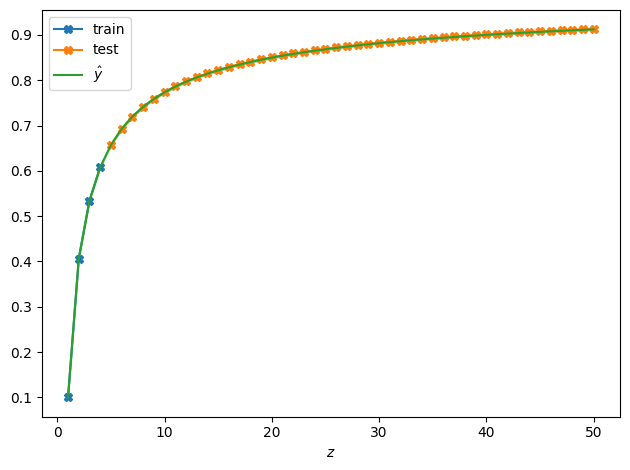

437 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
%%timeit -r 1 -n 1
k = 4
rho_pow3 = (1.0, 0.9, 0.6)
y = f_pow3(z, b, rho_pow3)

z_train, y_train = z[:k], y[:k]
z_test, y_test = z[k:], y[k:]

h_nparams = 1
h_model = lambda z, xi: pc_softplus(h_const1(z, b, xi))

f_nparams = 4
f_model = lambda z, rho: f_mmf4(z, b, rho)

# nparams = 3
# f_model = lambda z, rho: f_pow3(z, b, rho)

theta_hat = fit_learning_curve_model_mle(f_model, h_model, f_nparams, h_nparams, z_train, y_train)
rho_hat = theta_hat[:f_nparams]
xi_hat = theta_hat[f_nparams:]

y_hat = f_model(z, rho_hat)
sigma_hat = h_model(z, xi_hat)
ci = 1.96 * sigma_hat

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")
plt.plot(z, y_hat, label=r"$\hat{y}$")
plt.fill_between(z, y_hat-ci, y_hat+ci, color="green", alpha=0.25)
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

#### Linear

i: i_best=3 - nll: -23.95494842529297


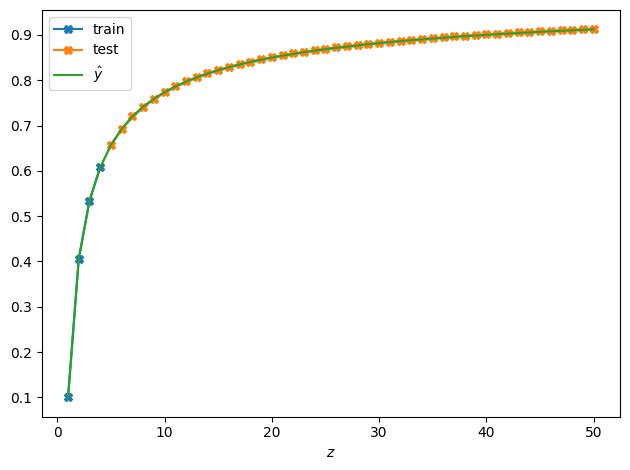

In [19]:
k = 4
rho_pow3 = (1.0, 0.9, 0.6)
y = f_pow3(z, b, rho_pow3)

z_train, y_train = z[:k], y[:k]
z_test, y_test = z[k:], y[k:]

h_nparams = 2
h_model = lambda z, xi: pc_softplus(h_lin2(z, b, xi))

f_nparams = 4
f_model = lambda z, rho: f_mmf4(z, b, rho)

theta_hat = fit_learning_curve_model_mle(f_model, h_model, f_nparams, h_nparams, z_train, y_train)
rho_hat = theta_hat[:f_nparams]
xi_hat = theta_hat[f_nparams:]

y_hat = f_model(z, rho_hat)
sigma_hat = h_model(z, xi_hat)
ci = 1.96 * sigma_hat

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")
plt.plot(z, y_hat, label=r"$\hat{y}$")
plt.fill_between(z, y_hat-ci, y_hat+ci, color="green", alpha=0.25)
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

### Learning Curves from LCDB

In [20]:
task_id = 351
model = "sklearn.ensemble.ExtraTreesClassifier"

curve = lcdb.get_curve(task_id, model)
anchors, _, scores_valid, _ = curve
anchors = np.array(anchors)
scores_valid = np.array(scores_valid)

# Exponential Budget Evolution
b_lcdb = lambda z: b_exp2(z, nu=[1, np.sqrt(2)])

k = 6

z_lcdb = np.arange(len(anchors)) + 1
z_lcdb_train, y_lcdb_train = z_lcdb[:k], scores_valid[:k, 0]
z_lcdb_test, y_lcdb_test = z_lcdb[k:], scores_valid[k:, 0]

#### Constant

i: i_best=6 - nll: -22.622501373291016


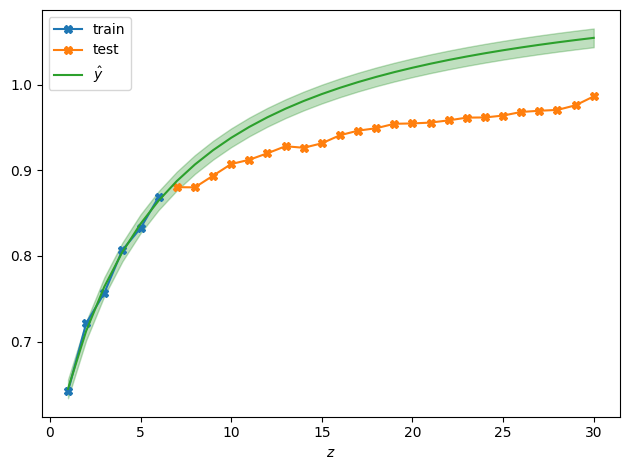

In [21]:
h_nparams = 1
h_model_lcdb = lambda z, xi: pc_softplus(h_const1(z, b_lcdb, xi))

f_nparams = 4
f_model_lcdb = lambda z, rho: f_mmf4(z, b_lcdb, rho)

theta_hat_lcdb = fit_learning_curve_model_mle(f_model_lcdb, h_model_lcdb, f_nparams, h_nparams, z_lcdb_train, y_lcdb_train)
rho_hat_lcdb = theta_hat_lcdb[:f_nparams]
xi_hat_lcdb = theta_hat_lcdb[f_nparams:]

y_hat_lcdb = f_model_lcdb(z_lcdb, rho_hat_lcdb)
sigma_hat_lcdb = h_model_lcdb(z_lcdb, xi_hat_lcdb)
ci = 1.96 * sigma_hat_lcdb

plt.figure()

plt.plot(z_lcdb_train, y_lcdb_train, marker="X", label="train")
plt.plot(z_lcdb_test, y_lcdb_test, marker="X", label="test")
plt.plot(z_lcdb, y_hat_lcdb, label=r"$\hat{y}$")
plt.fill_between(z_lcdb, y_hat_lcdb-ci, y_hat_lcdb+ci, color="green", alpha=0.25)
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

#### Linear

i: i_best=7 - nll: -23.094581604003906


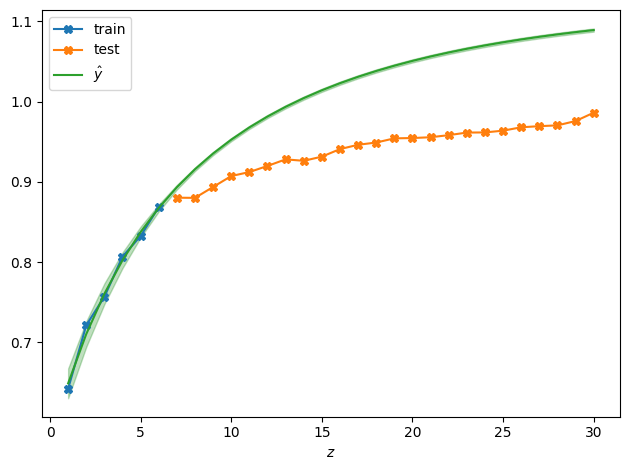

In [22]:
h_nparams = 2
h_model_lcdb = lambda z, xi: pc_softplus(h_lin2(z, b_lcdb, xi))

f_nparams = 4
f_model_lcdb = lambda z, rho: f_mmf4(z, b_lcdb, rho)

theta_hat_lcdb = fit_learning_curve_model_mle(f_model_lcdb, h_model_lcdb, f_nparams, h_nparams, z_lcdb_train, y_lcdb_train)
rho_hat_lcdb = theta_hat_lcdb[:f_nparams]
xi_hat_lcdb = theta_hat_lcdb[f_nparams:]

y_hat_lcdb = f_model_lcdb(z_lcdb, rho_hat_lcdb)
sigma_hat_lcdb = h_model_lcdb(z_lcdb, xi_hat_lcdb)
ci = 1.96 * sigma_hat_lcdb

plt.figure()

plt.plot(z_lcdb_train, y_lcdb_train, marker="X", label="train")
plt.plot(z_lcdb_test, y_lcdb_test, marker="X", label="test")
plt.plot(z_lcdb, y_hat_lcdb, label=r"$\hat{y}$")
plt.fill_between(z_lcdb, y_hat_lcdb-ci, y_hat_lcdb+ci, color="green", alpha=0.25)
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

### Learning Curves from HPOBench

In [23]:
# dataset = "fcnet_naval_propulsion_data"
# dataset = "fcnet_parkinsons_telemonitoring_data"
# dataset = "fcnet_protein_structure_data"
dataset = "fcnet_slice_localization_data"
path = "/Users/romainegele/Documents/Argonne/deephyper-benchmark/lib/HPOBench/tabular/build/HPOBench/data/fcnet_tabular_benchmarks"
path = os.path.join(path, f"{dataset}.hdf5")

hpobench_db = h5py.File(path, "r")

rs = np.random.RandomState(42)
selection = rs.choice(list(hpobench_db.keys()), size=1, replace=False)
hpobench_curve = {}
hpobench_curve["y"] = hpobench_db[selection[0]]["valid_loss"][0]
hpobench_curve["x"] = np.arange(1, len(hpobench_curve["y"]) + 1)

# possible preprocessing of the curve to enforce monotonicity
hpobench_curve["y"] = pd.Series(hpobench_curve["y"]).cummin().values

b_hpobench = lambda z: b_lin2(z)

k = 50

z_hpobench = np.arange(len(hpobench_curve["x"])) + 1
z_hpobench_train, y_hpobench_train = z_hpobench[:k], hpobench_curve["y"][:k]
z_hpobench_test, y_hpobench_test = z_hpobench[k:], hpobench_curve["y"][k:]

#### Constant

i: i_best=2 - nll: -290.17364501953125


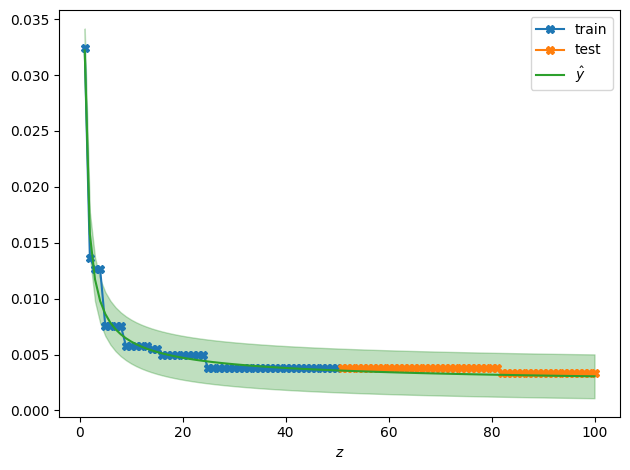

In [24]:
h_nparams = 1
h_model_hpobench = lambda z, xi: pc_softplus(h_const1(z, b_hpobench, xi))

f_nparams = 4
f_model_hpobench = lambda z, rho: f_mmf4(z, b_hpobench, rho)

theta_hat_hpobench = fit_learning_curve_model_mle(f_model_hpobench, h_model_hpobench, f_nparams, h_nparams, z_hpobench_train, y_hpobench_train)
rho_hat_hpobench = theta_hat_hpobench[:f_nparams]
xi_hat_hpobench = theta_hat_hpobench[f_nparams:]

y_hat_hpobench = f_model_hpobench(z_hpobench, rho_hat_hpobench)
sigma_hat_hpobench = h_model_hpobench(z_hpobench, xi_hat_hpobench)
ci = 1.96 * sigma_hat_hpobench

plt.figure()

plt.plot(z_hpobench_train, y_hpobench_train, marker="X", label="train")
plt.plot(z_hpobench_test, y_hpobench_test, marker="X", label="test")
plt.plot(z_hpobench, y_hat_hpobench, label=r"$\hat{y}$")
plt.fill_between(z_hpobench, y_hat_hpobench-ci, y_hat_hpobench+ci, color="green", alpha=0.25)
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

#### Linear

i: i_best=9 - nll: -291.35150146484375


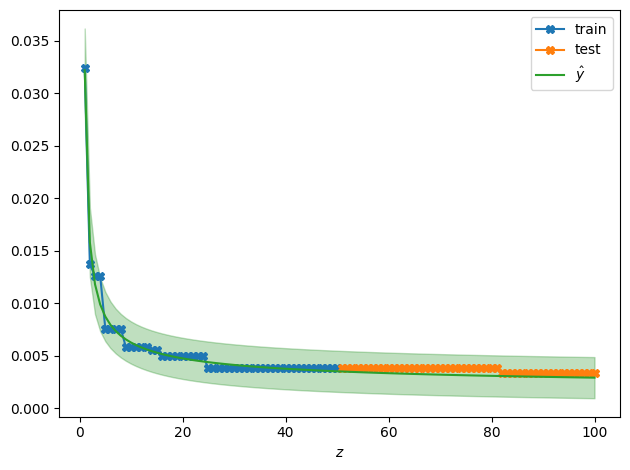

In [25]:
h_nparams = 2
h_model_hpobench = lambda z, xi: pc_softplus(h_lin2(z, b_hpobench, xi))

f_nparams = 4
f_model_hpobench = lambda z, rho: f_mmf4(z, b_hpobench, rho)

theta_hat_hpobench = fit_learning_curve_model_mle(f_model_hpobench, h_model_hpobench, f_nparams, h_nparams, z_hpobench_train, y_hpobench_train)
rho_hat_hpobench = theta_hat_hpobench[:f_nparams]
xi_hat_hpobench = theta_hat_hpobench[f_nparams:]

y_hat_hpobench = f_model_hpobench(z_hpobench, rho_hat_hpobench)
sigma_hat_hpobench = h_model_hpobench(z_hpobench, xi_hat_hpobench)
ci = 1.96 * sigma_hat_hpobench

plt.figure()

plt.plot(z_hpobench_train, y_hpobench_train, marker="X", label="train")
plt.plot(z_hpobench_test, y_hpobench_test, marker="X", label="test")
plt.plot(z_hpobench, y_hat_hpobench, label=r"$\hat{y}$")
plt.fill_between(z_hpobench, y_hat_hpobench-ci, y_hat_hpobench+ci, color="green", alpha=0.25)
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

## Epistemic Uncertainty with Ensemble

In [26]:
def fit_ensemble_members(f, nparams, z_train, y_train, ensemble_size=10, max_trials_per_fit=5, n_jobs=-1, random_state=None):
    
    random_state = check_random_state(random_state)
    random_states = random_state.randint(low=0, high=2**32, size=ensemble_size)
    
    f_wrapper = lambda seed: fit_learning_curve_model_least_square(
        f, nparams, z_train, y_train, max_trials=max_trials_per_fit, random_state=seed)
    rho_hat_list = Parallel(n_jobs=n_jobs)(delayed(f_wrapper)(seed) for seed in random_states)
    return np.array(rho_hat_list)


def predict_ensemble_members(f, z, rho, return_std=True, n_jobs=-1):
    f_wrapper = lambda rho: f(z, rho)
    y_list = Parallel(n_jobs=n_jobs)(delayed(f_wrapper)(rho_i) for rho_i in rho)
    y_list = np.array(y_list)
    
    mean_y_last = np.nanmean(y_list[:,-1])
    std_y_last = np.nanstd(y_list[:,-1])
    
    # remove outliers
    kappa = 3
    upper_bound = mean_y_last + kappa * std_y_last
    lower_bound = mean_y_last - kappa * std_y_last
    
    selection = (lower_bound < y_list[:,-1]) & (y_list[:,-1] < upper_bound)
    
    mean_y = np.nanmean(y_list[selection], axis=0)
    std_y = np.nanstd(y_list[selection], axis=0)
    
    if return_std:
        return mean_y, std_y, y_list
    return mean_y, y_list

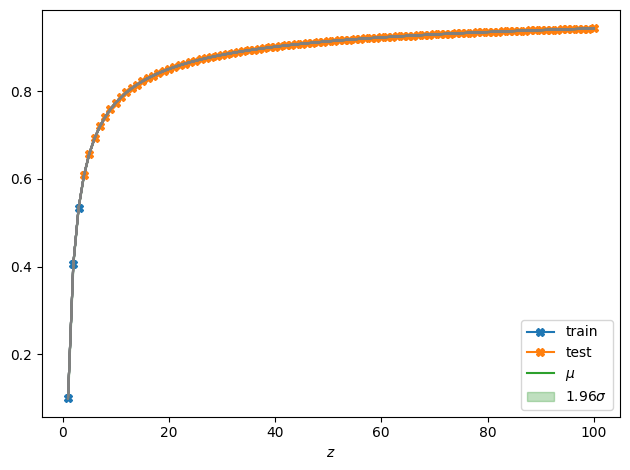

1.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [30]:
%%timeit -r 1 -n 1
k = 3
z_max = 100
z = (np.arange(z_max) + 1).astype(float)
b = lambda z: b_lin2(z)

rho_pow3 = (1.0, 0.9, 0.6)
y = f_pow3(z, b, rho_pow3)
# y = np.negative(y)

z_train, y_train = z[:k], y[:k]
z_test, y_test = z[k:], y[k:]

# nparams = 4
# f_model = lambda z, rho: f_mmf4(z, b, rho)

# nparams = 2
# f_model = lambda z, rho: f_loglin2(z, b, rho)

nparams = 3
f_model = lambda z, rho: f_pow3(z, b, rho)
    
rho_hat_list = fit_ensemble_members(f_model, nparams, z_train, y_train, ensemble_size=10, max_trials_per_fit=10)
mu_hat, std_hat, y_list = predict_ensemble_members(f_model, z, rho_hat_list)
ci = 1.96 * std_hat

y_list = np.array(y_list)

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")

plt.plot(z, mu_hat, label=r"$\mu$")
plt.fill_between(z, mu_hat-ci, mu_hat+ci, color="green", alpha=0.25, label=r"$1.96\sigma$")

for i in range(len(y_list)):
    plt.plot(z, y_list[i], color="grey")
    
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

### Toy-Example from Inverse Power Law

[[-0.10536057 -0.59999996]
 [-0.10536055 -0.59999997]
 [-0.10536057 -0.59999996]
 [-0.10536056 -0.59999995]
 [-0.10536055 -0.59999995]
 [-0.10536056 -0.59999995]
 [-0.10536058 -0.59999997]
 [-0.10536055 -0.59999995]
 [-0.10536056 -0.59999996]
 [-0.10536057 -0.59999995]]


/var/folders/l8/8k8c8x8152zc16r3jw25gw0c0000gn/T/ipykernel_22137/3026962065.py:27: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(y_list[selection], axis=0)
/Users/romainegele/miniforge3/envs/dh-arm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


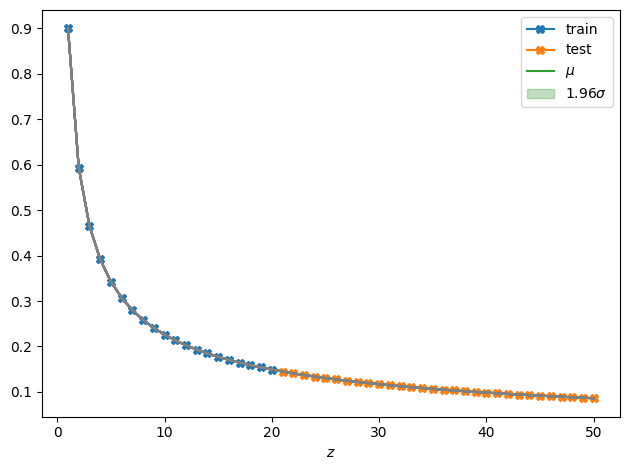

176 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [32]:
%%timeit -r 1 -n 1
k = 20
z_max = 50
z = (np.arange(z_max) + 1).astype(float)
b = lambda z: b_lin2(z)

rho_pow3 = (1.0, 0.9, 0.6)
y = 1 - f_pow3(z, b, rho_pow3)
# y = np.negative(y)

z_train, y_train = z[:k], y[:k]
z_test, y_test = z[k:], y[k:]

# nparams = 4
# f_model = lambda z, rho: f_mmf4(z, b, rho)

nparams = 2
f_model = lambda z, rho: f_loglin2(z, b, rho)

# nparams = 3
# f_model = lambda z, rho: f_pow3(z, b, rho)
    
rho_hat_list = fit_ensemble_members(f_model, nparams, z_train, y_train, ensemble_size=10, max_trials_per_fit=10)
print(rho_hat_list)
mu_hat, std_hat, y_list = predict_ensemble_members(f_model, z, rho_hat_list)
ci = 1.96 * std_hat

y_list = np.array(y_list)

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")

plt.plot(z, mu_hat, label=r"$\mu$")
plt.fill_between(z, mu_hat-ci, mu_hat+ci, color="green", alpha=0.25, label=r"$1.96\sigma$")

for i in range(len(y_list)):
    plt.plot(z, y_list[i], color="grey")
    
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

### Learning Curves from LCDB

(30,)
(30,)
[1.5380333e-06 1.0607018e-06 7.4055845e-07 4.4457067e-07 2.7382652e-07
 5.2960118e-08 1.6121696e-07 3.2359165e-07 4.6653022e-07 6.0244315e-07
 7.2305590e-07 8.4093818e-07 9.5210447e-07 1.0611424e-06 1.1480665e-06
 1.2561711e-06 1.3422368e-06 1.4247486e-06 1.4944391e-06 1.5970205e-06
 1.6561083e-06 1.7470953e-06 1.8004363e-06 1.8689244e-06 1.9630043e-06
 2.0202740e-06 2.0788448e-06 2.1394837e-06 2.2197808e-06 2.2615066e-06]


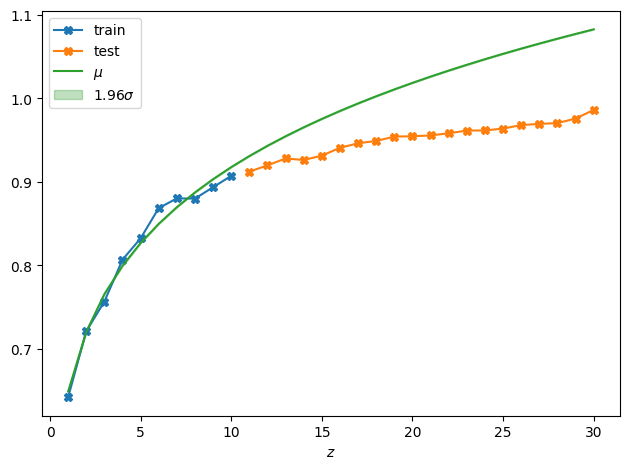

1.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [51]:
%%timeit -r 1 -n 1

task_id = 351
model = "sklearn.ensemble.ExtraTreesClassifier"

curve = lcdb.get_curve(task_id, model)
anchors, _, scores_valid, _ = curve
anchors = np.array(anchors)
scores_valid = np.array(scores_valid)

# b_lcdb = lambda z: b_exp2(z, nu=[anchors[0], np.sqrt(2)])
b_lcdb = lambda z: b_lin2(z)

k = 10

z_lcdb = np.arange(len(anchors)) + 1
z_lcdb_train, y_lcdb_train = z_lcdb[:k], scores_valid[:k, 0]
z_lcdb_test, y_lcdb_test = z_lcdb[k:], scores_valid[k:, 0]

# nparams = 4
# f_model_lcdb = lambda z, rho: f_mmf4(z, b_lcdb, rho)

nparams = 2
f_model_lcdb = lambda z, rho: f_loglin2(z, b_lcdb, rho)

rho_hat_lcdb_list = fit_ensemble_members(f_model_lcdb, nparams, z_lcdb_train, y_lcdb_train, ensemble_size=20, max_trials_per_fit=1)
mu_hat_lcdb, std_hat_lcdb, _ = predict_ensemble_members(f_model_lcdb, z_lcdb, rho_hat_lcdb_list)
ci_hat_lcdb = 1.96 * std_hat_lcdb

print(np.shape(mu_hat_lcdb))
print(np.shape(z_lcdb))
print(std_hat_lcdb)

plt.figure()

plt.plot(z_lcdb_train, y_lcdb_train, marker="X", label="train")
plt.plot(z_lcdb_test, y_lcdb_test, marker="X", label="test")

plt.plot(z_lcdb, mu_hat_lcdb, label=r"$\mu$")
plt.fill_between(z_lcdb, mu_hat_lcdb-ci_hat_lcdb, mu_hat_lcdb+ci_hat_lcdb, color="green", alpha=0.25, label=r"$1.96\sigma$")
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

### Learning Curves from HPOBench

In [37]:
dataset = "fcnet_naval_propulsion_data"
# dataset = "fcnet_parkinsons_telemonitoring_data"
# dataset = "fcnet_protein_structure_data"
# dataset = "fcnet_slice_localization_data"
path = "/Users/romainegele/Documents/Argonne/deephyper-benchmark/lib/HPOBench/tabular/build/HPOBench/data/fcnet_tabular_benchmarks"
path = os.path.join(path, f"{dataset}.hdf5")

hpobench_db = h5py.File(path, "r")

rs = np.random.RandomState(42)
selection = rs.choice(list(hpobench_db.keys()), size=100, replace=False)
idx = 0
hpobench_curve = {}
hpobench_curve["y"] = hpobench_db[selection[idx]]["valid_loss"][0]
hpobench_curve["x"] = np.arange(1, len(hpobench_curve["y"]) + 1)

# possible preprocessing of the curve to enforce monotonicity
hpobench_curve["y"] = pd.Series(hpobench_curve["y"]).cummin().values

b_hpobench = lambda z: b_lin2(z)

k = 50

z_hpobench = np.arange(len(hpobench_curve["x"])) + 1
z_hpobench_train, y_hpobench_train = z_hpobench[:k], hpobench_curve["y"][:k]
z_hpobench_test, y_hpobench_test = z_hpobench[k:], hpobench_curve["y"][k:]

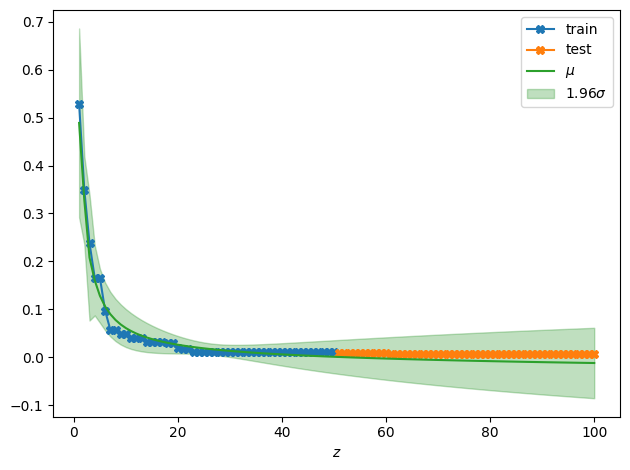

279 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [24]:
%%timeit -r 1 -n 1

rho_hat_hpobench_list = fit_ensemble_members(f_model_hpobench, nparams, z_hpobench_train, y_hpobench_train, ensemble_size=15, max_trials_per_fit=5)
mu_hat_hpobench, std_hat_hpobench = predict_ensemble_members(f_model_hpobench, z_hpobench, rho_hat_hpobench_list)
ci_hat_hpobench = 1.96 * std_hat_hpobench

plt.figure()

plt.plot(z_hpobench_train, y_hpobench_train, marker="X", label="train")
plt.plot(z_hpobench_test, y_hpobench_test, marker="X", label="test")

plt.plot(z_hpobench, mu_hat_hpobench, label=r"$\mu$")
plt.fill_between(z_hpobench, mu_hat_hpobench-ci_hat_hpobench, mu_hat_hpobench+ci_hat_hpobench, color="green", alpha=0.25, label=r"$1.96\sigma$")
plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

## Epistemic Uncertainty with Bayesian Inference

In [3]:
from deephyper.stopper._lcmodel_stopper import BayesianLearningCurveRegressor
from scipy.stats import norm

### Learning Curves from LCDB

duration=1.083 sec.
pi=0.9999999999998096


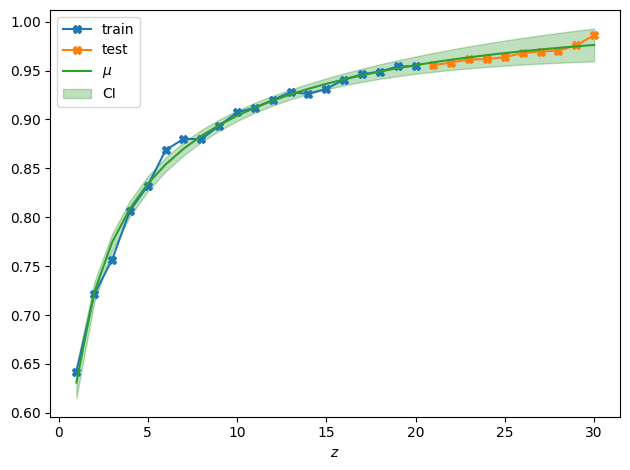

In [41]:
# %%timeit -r 1 -n 1

# TOY
# k = 10
# z_max = 100
# z = (np.arange(z_max) + 1).astype(float)
# b = lambda z: b_lin2(z)

# rho_pow3 = (1.0, 0.9, 0.6)
# y = f_pow3(z, b, rho_pow3)

# z_train, y_train = z[:k], y[:k]
# z_test, y_test = z[k:], y[k:]

# LCDB
task_id = 351
model = "sklearn.ensemble.ExtraTreesClassifier"

curve = lcdb.get_curve(task_id, model)
anchors, _, scores_valid, _ = curve
anchors = np.array(anchors)
scores_valid = np.array(scores_valid)

k = 20

z = np.arange(len(anchors)) + 1
z_train, y_train = z[:k], scores_valid[:k, 0]
z_test, y_test = z[k:], scores_valid[k:, 0]

model = BayesianLearningCurveRegressor(verbose=0)

t1 = time.time()
model.fit(z_train, y_train)
mean_mu, std_mu = model.predict(z)
duration = time.time() - t1
print(f"{duration=:.3f} sec.")

pi = 1 - norm.cdf(y[-1], loc=mean_mu[-1], scale=std_mu[-1])
print(f"{pi=}")

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")

plt.plot(z, mean_mu, label=r"$\mu$")
plt.fill_between(z, mean_mu-1.96*std_mu, mean_mu+1.96*std_mu, color="green", alpha=0.25, label="CI")

plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

duration=0.059 sec.


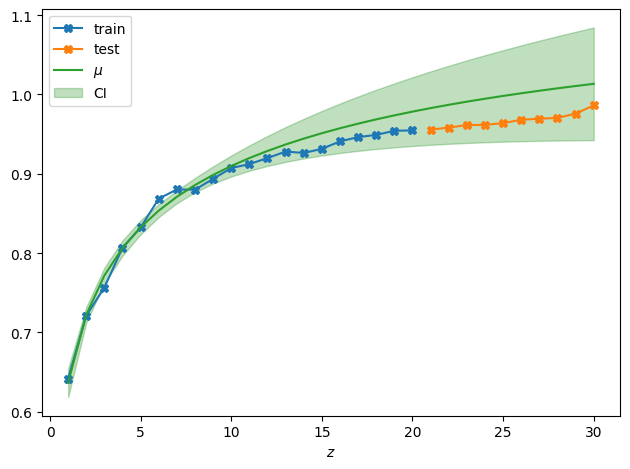

In [121]:
# %%timeit -r 1 -n 1

k = 20

z = np.arange(len(anchors)) + 1
z_train, y_train = z[:k], scores_valid[:k, 0]
z_test, y_test = z[k:], scores_valid[k:, 0]

t1 = time.time()
model.fit(z_train, y_train, update_prior=True)
mean_mu, std_mu = model.predict(z)
duration = time.time() - t1
print(f"{duration=:.3f} sec.")

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")

plt.plot(z, mean_mu, label=r"$\mu$")
plt.fill_between(z, mean_mu-1.96*std_mu, mean_mu+1.96*std_mu, color="green", alpha=0.25, label="CI")

plt.xlabel(r"$z$")
plt.legend()

plt.tight_layout()
plt.show()

### Learning Curves from HPOBench

sample: 100%|██████████████████████████████████████████████████████████████| 1200/1200 [00:01<00:00, 727.38it/s, 255 steps of size 2.35e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    rho[0]     -2.10      0.57     -2.02     -2.96     -1.18    270.04      1.00
    rho[1]      1.53      0.61      1.42      0.58      2.45    415.82      1.00
    rho[2]      0.70      0.51      0.57      0.02      1.50    249.18      1.00
    rho[3]      0.36      0.14      0.33      0.17      0.58    230.24      1.01
     sigma      0.07      0.01      0.07      0.06      0.08    402.48      1.00

Number of divergences: 3
duration=1.759 sec.
pi=DeviceArray(0.022, dtype=float32)


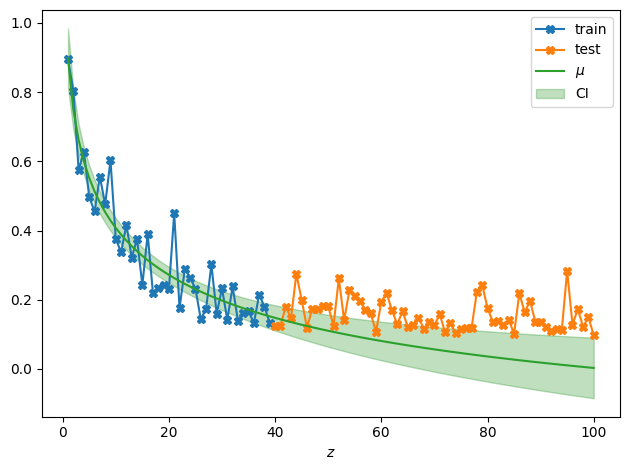

In [53]:
from deephyper.stopper._lcmodel_stopper import *


dataset = "fcnet_naval_propulsion_data"
# dataset = "fcnet_parkinsons_telemonitoring_data"
# dataset = "fcnet_protein_structure_data"
# dataset = "fcnet_slice_localization_data"
path = "/Users/romainegele/Documents/Argonne/deephyper-benchmark/lib/HPOBench/tabular/build/HPOBench/data/fcnet_tabular_benchmarks"
path = os.path.join(path, f"{dataset}.hdf5")

hpobench_db = h5py.File(path, "r")

rs = np.random.RandomState(42)
selection = rs.choice(list(hpobench_db.keys()), size=100, replace=False)

idx = 40
hpobench_curve = {}
hpobench_curve["y"] = hpobench_db[selection[idx]]["valid_loss"][0]
hpobench_curve["x"] = np.arange(1, len(hpobench_curve["y"]) + 1)

# possible preprocessing of the curve to enforce monotonicity
# hpobench_curve["y"] = pd.Series(hpobench_curve["y"]).values
hpobench_curve["y"] = np.negative(hpobench_curve["y"])
# X = hpobench_curve["y"]
# hpobench_curve["y"] = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


k = 39

z = np.arange(len(hpobench_curve["x"])) + 1
z_train, y_train = z[:k], hpobench_curve["y"][:k]
z_test, y_test = z[k:], hpobench_curve["y"][k:]


model = BayesianLearningCurveRegressor(
    # f_model=f_loglin2, f_model_num_params=2,
    # f_model=f_loglin3, f_model_num_params=3,
    # f_model=f_loglin4, f_model_num_params=4,
    # f_model=f_pow3, f_model_num_params=3,
    f_model=f_mmf4, f_model_num_params=4,
    # f_model=f_logloglin2, f_model_num_params=2,
    # f_model=f_pow4, f_model_num_params=4,
    # f_model=f_weibull4, f_model_num_params=4,
    # f_model=f_janoschek4, f_model_num_params=4,
    max_trials_ls_fit=10,
    mcmc_num_samples=1_000,
    verbose=1,
)

t1 = time.time()
model.fit(z_train, y_train)
mean_mu, std_mu = model.predict(z)
duration = time.time() - t1
print(f"{duration=:.3f} sec.")

# pi = 1 - norm.cdf(hpobench_curve["y"][-1], loc=mean_mu[-1], scale=std_mu[-1])
pi = model.prob(X=[z[-1]], condition=lambda y_hat: y_hat <= hpobench_curve["y"][-1])[0]
print(f"{pi=}")

plt.figure()

plt.plot(z_train, -y_train, marker="X", label="train")
plt.plot(z_test, -y_test, marker="X", label="test")

plt.plot(z, -mean_mu, label=r"$\mu$")
plt.fill_between(z, -mean_mu-1.96*std_mu, -mean_mu+1.96*std_mu, color="green", alpha=0.25, label="CI")

plt.xlabel(r"$z$")
# plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()

{'Param:0': OrderedDict([('mean', 0.022520466), ('std', 0.08798632), ('median', 0.041011333), ('5.0%', -0.048991065), ('95.0%', 0.11315336), ('n_eff', 6117.165885802829), ('r_hat', 1.143084057524371)])}


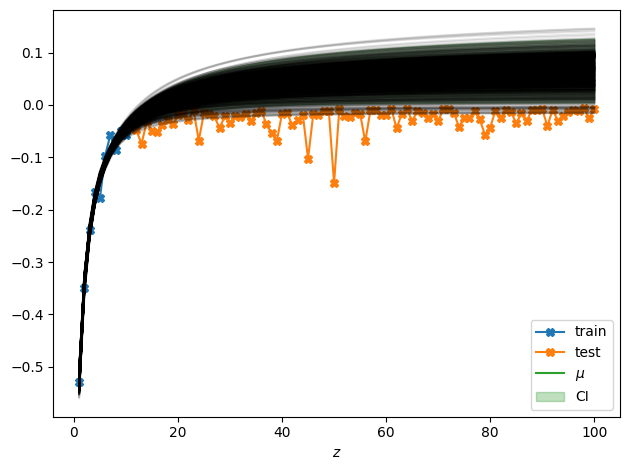

In [76]:
from numpyro.diagnostics import hpdi, summary

post_samples = model.predict_posterior_samples(z)

infos = summary(post_samples)
print(infos)

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")

plt.plot(z, mean_mu, label=r"$\mu$")
plt.fill_between(z, mean_mu-1.96*std_mu, mean_mu+1.96*std_mu, color="green", alpha=0.25, label="CI")

for pred_i in post_samples:
    plt.plot(z, pred_i, color="black", alpha=0.1)


plt.xlabel(r"$z$")
# plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
from pybnn.lc_extrapolation.curvemodels import MLCurveModel
from pybnn.lc_extrapolation.learning_curves import MCMCCurveModelCombination


dataset = "fcnet_naval_propulsion_data"
# dataset = "fcnet_parkinsons_telemonitoring_data"
# dataset = "fcnet_protein_structure_data"
# dataset = "fcnet_slice_localization_data"
path = "/Users/romainegele/Documents/Argonne/deephyper-benchmark/lib/HPOBench/tabular/build/HPOBench/data/fcnet_tabular_benchmarks"
path = os.path.join(path, f"{dataset}.hdf5")

hpobench_db = h5py.File(path, "r")

rs = np.random.RandomState(42)
selection = rs.choice(list(hpobench_db.keys()), size=100, replace=False)
idx = 0
hpobench_curve = {}
hpobench_curve["y"] = hpobench_db[selection[idx]]["valid_loss"][0]
hpobench_curve["x"] = np.arange(1, len(hpobench_curve["y"]) + 1)
hpobench_curve["y"] = np.negative(hpobench_curve["y"])


k = 20

z = np.arange(len(hpobench_curve["x"])) + 1
z_train, y_train = z[:k], hpobench_curve["y"][:k]
z_test, y_test = z[k:], hpobench_curve["y"][k:]


model = MCMCCurveModelCombination(xlim=100, recency_weighting=False)

t1 = time.time()
model.fit(z_train, y_train)

mean_mu, std_mu = [], []
for i in tqdm(range(len(z))):
    pred_i = model.predictive_distribution(int(z[i]))
    mean_i, std_i = pred_i.mean(), pred_i.std()
    mean_mu.append(mean_i)
    std_mu.append(std_i)
mean_mu, std_mu = np.asarray(mean_mu), np.asarray(std_mu)

# mean_mu, std_mu = model.predict(z)
# duration = time.time() - t1
# print(f"{duration=:.3f} sec.")

# pi = 1 - norm.cdf(hpobench_curve["y"][-1], loc=mean_mu[-1], scale=std_mu[-1])
# print(f"{pi=}")

# plt.figure()

# plt.plot(z_train, y_train, marker="X", label="train")
# plt.plot(z_test, y_test, marker="X", label="test")

# plt.plot(z, mean_mu, label=r"$\mu$")
# plt.fill_between(z, mean_mu-1.96*std_mu, mean_mu+1.96*std_mu, color="green", alpha=0.25, label="CI")

# plt.xlabel(r"$z$")
# # plt.yscale("log")
# plt.legend()

# plt.tight_layout()
# plt.show()

ML fit of model weibull is out of bound range [0.0, 100.] at xlim.
ML fit of model mmf is out of bound range [0.0, 100.] at xlim.
ML fit of model janoschek is out of bound range [0.0, 100.] at xlim.
ML fit of model dr_hill_zero_background is out of bound range [0.0, 100.] at xlim.
ML fit of model log_power is out of bound range [0.0, 100.] at xlim.
ML fit of model exp4 is out of bound range [0.0, 100.] at xlim.


  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
mean_i

0.10118318537988437

pi=0.9979820031125706


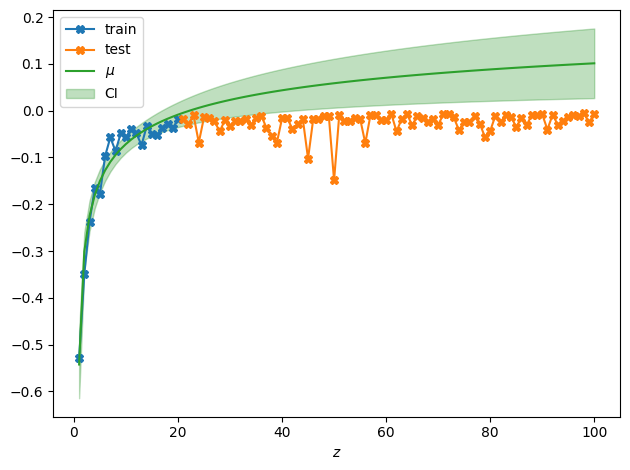

In [26]:
from scipy.stats import norm


pi = 1 - norm.cdf(hpobench_curve["y"][-1], loc=mean_mu[-1], scale=std_mu[-1])
print(f"{pi=}")

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")

plt.plot(z, mean_mu, label=r"$\mu$")
plt.fill_between(z, mean_mu-1.96*std_mu, mean_mu+1.96*std_mu, color="green", alpha=0.25, label="CI")

plt.xlabel(r"$z$")
# plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
import numpy as np

from naslib.predictors.lce.parametric_model import (
    model_name_list, # remove models improved performance
    model_name_list_original,
    model_config,
    construct_parametric_model,
)
from naslib.predictors.lce.parametric_ensemble import ParametricEnsemble


ensemble = ParametricEnsemble(
    [construct_parametric_model(model_config, name) for name in model_name_list]
)

final_epoch = 100
N = 1000

learning_curve = y_train
ensemble.mcmc(learning_curve, N=N, var=0.001)
mean_mu, std_mu = ensemble.mcmc_sample_predict(z, return_std=True)

Completed with acceptance rate 0.649 in 2.7387478351593018 seconds.


In [33]:
model_name_list_original

['vapor_pressure',
 'pow3',
 'logloglinear',
 'logpower',
 'pow4',
 'mmf',
 'exp4',
 'janoschek',
 'weibull',
 'ilog2',
 'hill3']

pi=1.0


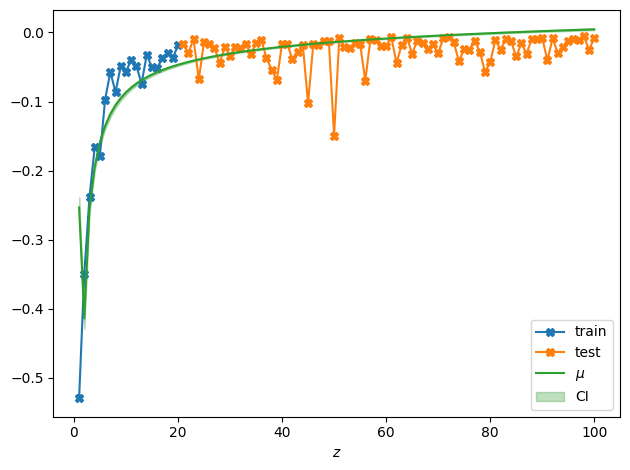

In [34]:
from scipy.stats import norm


pi = 1 - norm.cdf(hpobench_curve["y"][-1], loc=mean_mu[-1], scale=std_mu[-1])
print(f"{pi=}")

plt.figure()

plt.plot(z_train, y_train, marker="X", label="train")
plt.plot(z_test, y_test, marker="X", label="test")

plt.plot(z, mean_mu, label=r"$\mu$")
plt.fill_between(z, mean_mu-1.96*std_mu, mean_mu+1.96*std_mu, color="green", alpha=0.25, label="CI")

plt.xlabel(r"$z$")
# plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
std_mu

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

## Fast Convex Optimization to Find the budget maximizing Utility

In [21]:
def maximize_utility(u, z_min, z_max):
    
    def neg_u(z):
        return -u(z[0])
    
    dneg_u = grad(neg_u)

    z0 = np.array([(z_min + z_max) / 2])
    res = minimize(
        neg_u,
        z0,
        method="BFGS",
        jac=dneg_u,
        options={"disp": True},
    )
    z_opt = np.round(res.x)[0]
    return z_opt

Optimization terminated successfully.
         Current function value: -5.110955
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
z_opt=21.0


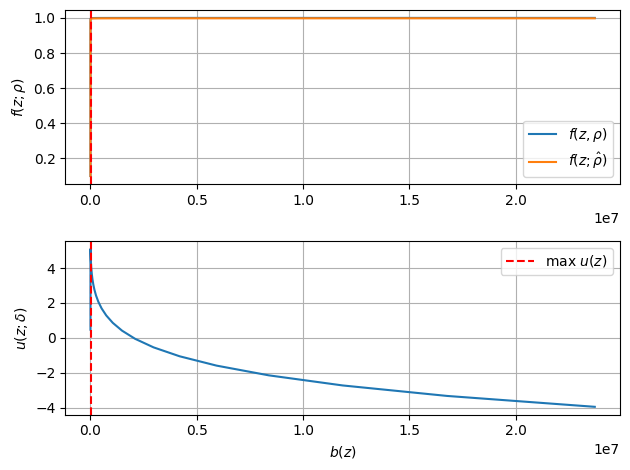

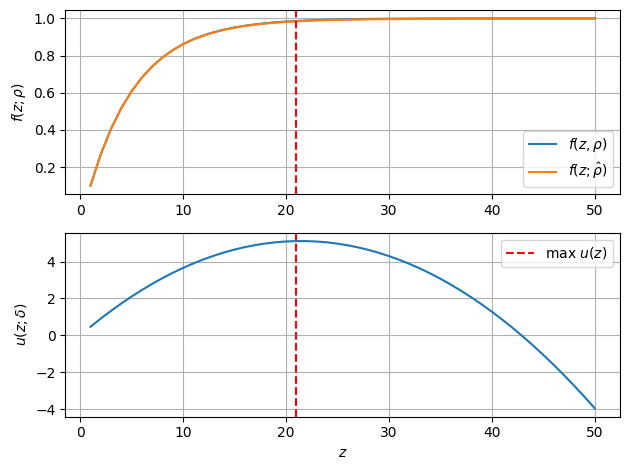

In [27]:
f_model_hat = lambda z: f_model(z, rho_hat)
df_model_hat = grad(f_model_hat)

# delta =  df_model_hat(float(z_max)) / db(float(z_max))
delta = 0.001/b(50)

u = lambda z: u_log2(z, delta, z_max, b, db, df_model_hat)
vu = vmap(u)

z_opt = maximize_utility(u, z_min=1, z_max=z_max)
print(f"{z_opt=}")

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(vb(z), y, label=r"$f(z,\rho)$")
plt.plot(vb(z), f_model_hat(z), label=r"$f(z;\hat{\rho})$")
plt.axvline(b(z_opt), linestyle="--", color="red")
plt.ylabel(r"$f(z;\rho)$")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(vb(z), vu(z))
plt.axvline(b(z_opt), linestyle="--", color="red", label=r"$\max~u(z)$")
plt.ylabel(r"$u(z;\delta)$")
plt.xlabel(r"$b(z)$")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(z, y, label=r"$f(z,\rho)$")
plt.plot(z, f_model_hat(z), label=r"$f(z;\hat{\rho})$")
plt.axvline(z_opt, linestyle="--", color="red")
plt.ylabel(r"$f(z;\rho)$")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(z, vu(z))
plt.axvline(z_opt, linestyle="--", color="red", label=r"$\max~u(z)$")
plt.ylabel(r"$u(z;\delta)$")
plt.xlabel(r"$z$")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
y_opt = float(f_model_hat(z_opt))
y_max = float(f_model_hat(z_max))
print(f"{y_opt=:.3f}")
print(f"{y_max=:.3f}")
print(f"budget saved: {b(z_max)-b(z_opt)}")

y_opt=0.984
y_max=0.998
budget saved: 23725508.0


In [32]:
# it would be better to have this quantity exactly equal to y_max?
float((b(z_max) - b(z_opt))*delta + y_opt)

0.9850873947143555

## Hyperparameter Optimization Toy Problem with Inverse Power Law (POW3)

We use the $f_{pow3}$ model to simulate a toy problem.

In [15]:
from deephyper.problem import HpProblem


problem = HpProblem()
problem.add_hyperparameter((1e-6, 10, "log-uniform"), "alpha")
problem.add_hyperparameter((1.0, 10.0), "beta")
problem.add_hyperparameter((0.1, 0.5), "gamma")

gamma, Type: UniformFloat, Range: [0.1, 0.5], Default: 0.3

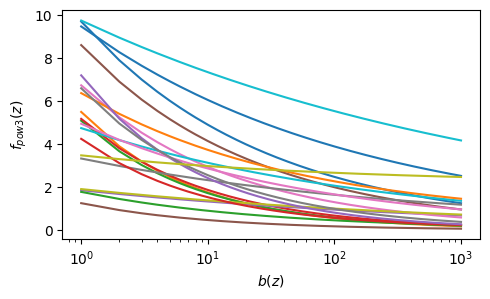

In [16]:

b = lambda z: linear_budget(z, alpha=1, z0=1)
vb = vmap(b)

n_samples = 20
z_range = np.arange(1_000) + 1

plt.figure(figsize=(5, 5/1.618))

for i in range(n_samples):
    config = problem.space.sample_configuration().get_dictionary()
    rho = [config["alpha"], -config["beta"], config["gamma"]]
    f = lambda z: f_pow3(z, b, rho)
    vf = vmap(f)
    
    y = vf(z_range)
    plt.plot(vb(z_range), y)

plt.xscale("log")
# plt.yscale("log")
plt.ylabel(r"$f_{pow3}(z)$")
plt.xlabel(r"$b(z)$")
plt.tight_layout()
plt.savefig("sample-curves-pow3-example.png", dpi=360)
plt.show()    

## The ALC from the AutoDL Competition

\begin{align}
ALC &= \int_0^1 s(t) d\tilde{t}(t) \\ 
    &= \int_0^T s(t) \tilde{t'}(t)dt \\
    &= \frac{1}{\log(1 + T/t_0)} \int_0^1 \frac{s(t)}{t+t_0}dt
\end{align}

where $s(t)$ is the performance score (e.g. NAUC: normalized AUC) and $\tilde{t}$ is the transformed time:

$$\tilde{t}(t) = \frac{\log(1+ t/t_0)}{\log(1+T/t_0)}$$

The NAUC (normalized area under ROC curve) is:

$$NAUC = 2 \times AUC - 1$$

In our case we have:
* $b(z)$ which model the evolution of budget
* $f(z)$ which model the evolution of the performance

Therefore we could have:

$$ a(z) = \int_{z_\text{min}}^z f(z) dz$$

The area under the learning curve. But, in our case the evaluated model $f$ can be pruned before $z_\text{max}$ therefore it we define the "completed" area under the learning curve as:

$$ a(z_\text{max}) = \int_{z_\text{min}}^{z_\text{max}} f(z) dz$$ the estimated ALC if budget was maximum.

If BO maximise, the $a(z)$ it is scalable! No need to estimate the full learning curve anymore.

The "completed" area under the learnin curve in a discrete form assuming incrementations of +1 between steps is:
$$ a(z) = \sum_{z \in Z_{obs} \setminus\{ z_{min} \} \cup \{ z_{max} \}} f(z-1)$$

In [25]:
def alc(z, f, z_max):
    """Area under the learning curve."""
    assert len(z) == len(f)
    assert z[-1] <= z_max
    area = 0
    for i in range(1, len(z)):
        # z: is always monotinic increasing but not f!
        area += float((z[i] - z[i-1]) * f[i-1])
    if z[-1] < z_max:
        area += float((z_max - z[-1]) * f[-1])
    return area

Should the $a(\cdot)$ be a function of $z$ (the steps) or the budget $b$? If we use the budget $b$ then expensive steps well be more accounted for that not expansive steps. Therefore it is better to use $z$ directly (doing so is similar to mapping the budget to its linear counterpart, a bit like a log would do for an exponential).

alc_z=46.74277460575104
alc_b=23726525.326471403


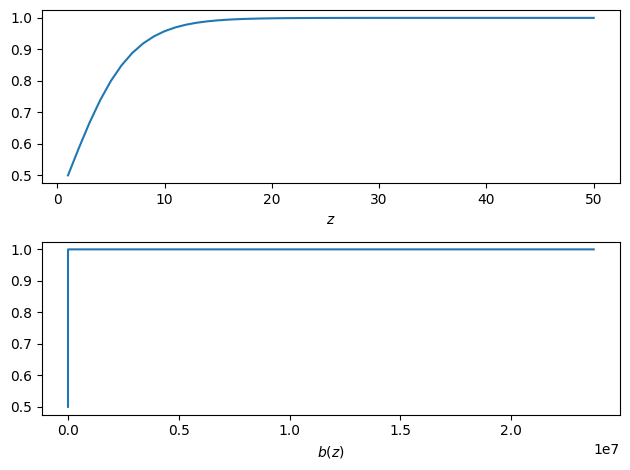

In [32]:
# modeling the iterations
z_max = 50
z = (np.arange(z_max) + 1).astype(float)

# modeling the budget

# linear budget
# b = lambda z: linear_budget(z, alpha=1, z0=1)

# exponential budget
b = lambda z: exp_budget(z, beta=jnp.sqrt(2), z0=1)

vb = vmap(b)

# modeling the learning curve function
rho_mmf4 = (1e-6, 1.0, 1.0, 1.0)
f = lambda z: f_mmf4(z, b, rho_mmf4)
vf = vmap(f)

alc_z = alc(z, vf(z), z_max)
print(f"{alc_z=}")

alc_b = alc(vb(z), vf(z), b(float(z_max)))
print(f"{alc_b=}")


plt.figure()
plt.subplot(2, 1, 1)
plt.plot(z, vf(z))
plt.xlabel(r"$z$")

plt.subplot(2, 1, 2)
plt.plot(vb(z), vf(z))
plt.xlabel(r"$b(z)$")

plt.tight_layout()
plt.show()

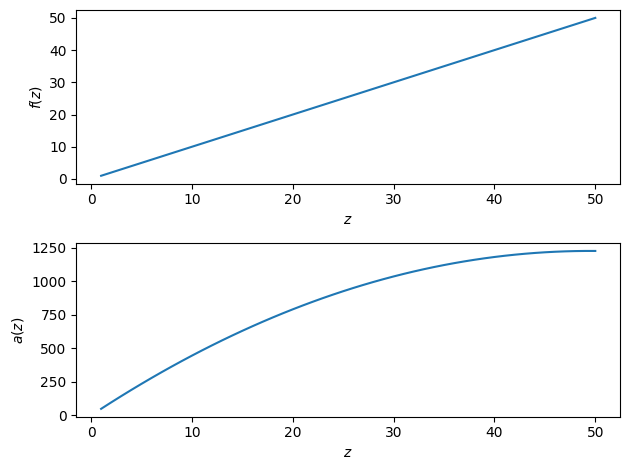

In [39]:
z_max = 50
z = (np.arange(z_max) + 1).astype(float)

f = lambda z: z
vf = vmap(f)

alc_z = []
for i in range(len(z)):
    alc_zi = alc(z[:i+1], vf(z[:i+1]), z_max)
    alc_z.append(alc_zi)


plt.figure()
plt.subplot(2, 1, 1)
plt.plot(z, vf(z))
plt.xlabel(r"$z$")
plt.ylabel(r"$f(z)$")

plt.subplot(2, 1, 2)
plt.plot(z, alc_z)
plt.xlabel(r"$z$")
plt.ylabel(r"$a(z)$")

plt.tight_layout()
plt.show()